D:\FCIS Content\Fourth year\GP\phase 1\Z: Found 100 text files


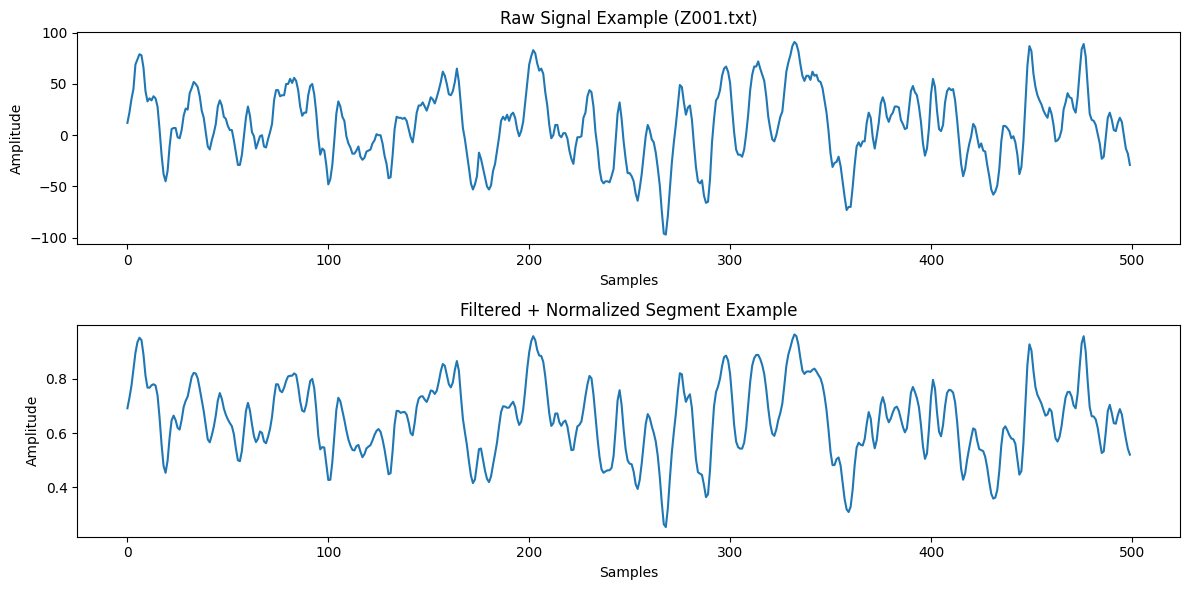

Saved NORMAL → (400, 868) to NPY & TXT
D:\FCIS Content\Fourth year\GP\phase 1\O: Found 100 text files
Saved NORMAL → (400, 868) to NPY & TXT
D:\FCIS Content\Fourth year\GP\phase 1\N: Found 100 text files
Saved INTERICTAL → (400, 868) to NPY & TXT
D:\FCIS Content\Fourth year\GP\phase 1\F: Found 100 text files
Saved INTERICTAL → (400, 868) to NPY & TXT
D:\FCIS Content\Fourth year\GP\phase 1\S: Found 100 text files
Saved ICTAL → (400, 868) to NPY & TXT
All data merged and saved → X: (2000, 868), y: (2000,)
Preprocessing complete!


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import savemat

# Bandpass Filter

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Preprocessing Function

def preprocess_signal(signal, fs=173.61, segment_length=None):
    # Bandpass Filter
    filtered = bandpass_filter(signal, 0.5, 50, fs)

    # Segmentation
    if segment_length is None:
        segment_length = int(5 * fs)  # 5-second default
    segments = []
    for start in range(0, len(filtered), segment_length):
        end = start + segment_length
        if end <= len(filtered):
            segments.append(filtered[start:end])
    segments = np.array(segments)  # shape = (num_segments, segment_length)

    # Normalization (Min–Max per segment)
    scaler = MinMaxScaler(feature_range=(0, 1))
    normed_segments = np.zeros_like(segments)
    for i in range(segments.shape[0]):
        normed_segments[i] = scaler.fit_transform(segments[i].reshape(-1, 1)).flatten()

    return normed_segments, filtered


# Load & Preprocess Dataset

def load_and_preprocess_bonn(root_dir, save_dir, plot_example=True):
    # Map folders to classes
    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    all_segments, all_labels = [], []
    plotted = False

    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "**", "*.txt"), recursive=True)

        print(f"{folder_path}: Found {len(files)} text files")

        class_segments = []
        for i, file in enumerate(files):
            try:
                data = np.loadtxt(file)
                normed_segments, filtered = preprocess_signal(data)

                # Plot one example
                if plot_example and not plotted:
                    plt.figure(figsize=(12, 6))
                    plt.subplot(2, 1, 1)
                    plt.plot(data[:500])
                    plt.title(f"Raw Signal Example ({os.path.basename(file)})")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")

                    plt.subplot(2, 1, 2)
                    plt.plot(normed_segments[0][:500])
                    plt.title("Filtered + Normalized Segment Example")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    plotted = True

                class_segments.append(normed_segments)
            except Exception as e:
                print(f"Error reading {file}: {e}")

        if not class_segments:
            print(f"No valid data found for {folder}")
            continue

        class_segments = np.vstack(class_segments)
        labels = np.full(len(class_segments), label)
        all_segments.append(class_segments)
        all_labels.append(labels)

        # --- Save per class ---
        os.makedirs(save_dir, exist_ok=True)

        np.save(os.path.join(save_dir, f"{label}_X.npy"), class_segments)
        np.save(os.path.join(save_dir, f"{label}_y.npy"), labels)
        np.savetxt(os.path.join(save_dir, f"{label}_X.txt"), class_segments, fmt="%.6f")
        np.savetxt(os.path.join(save_dir, f"{label}_y.txt"), labels, fmt="%s")

        print(f"Saved {label} → {class_segments.shape} to NPY & TXT")

    # --- Merge all ---
    if not all_segments:
        raise RuntimeError("❌ No valid data loaded! Check folder paths or file format.")

    X = np.vstack(all_segments)
    y = np.concatenate(all_labels)

    np.save(os.path.join(save_dir, "ALL_X.npy"), X)
    np.save(os.path.join(save_dir, "ALL_y.npy"), y)
    np.savetxt(os.path.join(save_dir, "ALL_X.txt"), X, fmt="%.6f")
    np.savetxt(os.path.join(save_dir, "ALL_y.txt"), y, fmt="%s")

    print(f"All data merged and saved → X: {X.shape}, y: {y.shape}")

    return X, y

# Main
if __name__ == "__main__":
    root = r"D:\FCIS Content\Fourth year\GP\phase 1"  # Path containing Z, O, N, F, S folders
    save_dir = os.path.join(root, "preprocessed")

    X, y = load_and_preprocess_bonn(root, save_dir, plot_example=True)
    print("Preprocessing complete!")


D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\Z: Found 100 text files


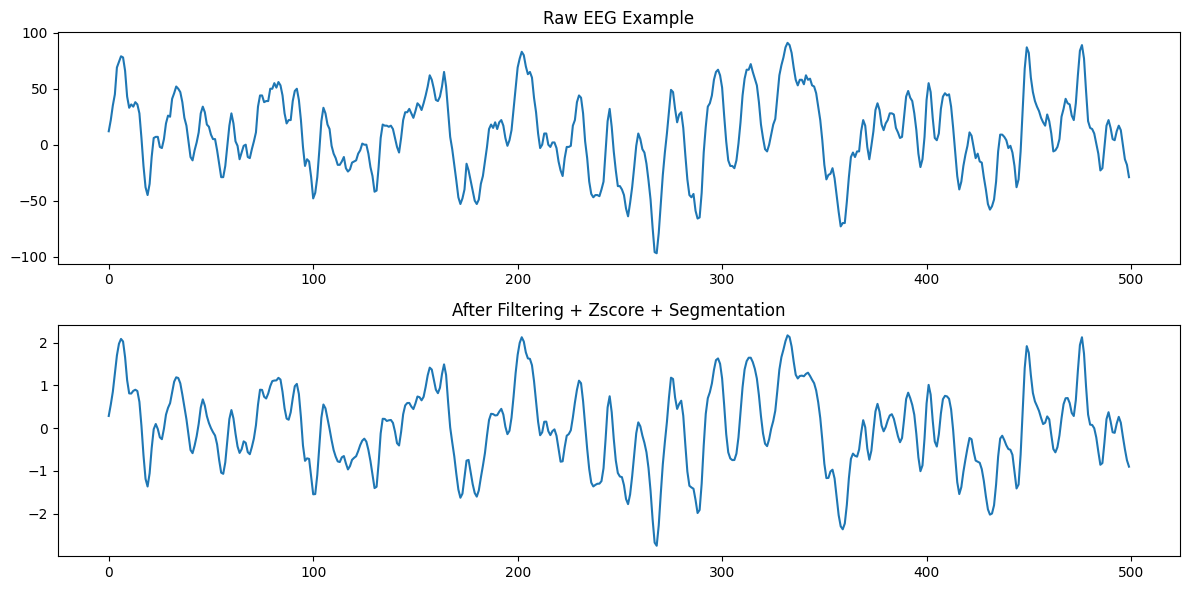

D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\O: Found 100 text files
D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\N: Found 100 text files
D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\F: Found 100 text files
D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\S: Found 100 text files
Saved → X: (2500, 819), y: (2500,)
Preprocessing complete!


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ----------------------------------------------------
#  Bandpass Filter
# ----------------------------------------------------
def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


# ----------------------------------------------------
#  Preprocessing with Fixed N Segments + Z-score
# ----------------------------------------------------
def preprocess_signal(signal, num_segments=5, fs=173.61):
    
    # 1) Bandpass Filter
    filtered = bandpass_filter(signal, 0.5, 50, fs)
    
    # 2) Split into equal segments (NO sample loss)
    L = len(filtered)
    seg_len = L // num_segments   # ensures equal segments
    segments = []

    for i in range(num_segments):
        start = i * seg_len
        end = (i+1) * seg_len
        segments.append(filtered[start:end])

    segments = np.array(segments)

    # 3) Z-score normalization (per segment)
    normed_segments = np.zeros_like(segments)
    for i in range(num_segments):
        seg = segments[i]
        mean = np.mean(seg)
        std = np.std(seg) + 1e-8
        normed_segments[i] = (seg - mean) / std

    return normed_segments, filtered



# ----------------------------------------------------
#  Load & Preprocess Dataset
# ----------------------------------------------------
def load_and_preprocess_bonn(root_dir, save_dir, num_segments=5, plot_example=True):

    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    all_segments, all_labels = [], []
    plotted = False

    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "*.txt"))

        print(f"{folder_path}: Found {len(files)} text files")

        class_segments = []
        for file in files:
            try:
                data = np.loadtxt(file)
                normed_segments, filtered = preprocess_signal(data, num_segments=num_segments)

                # Plot once
                if plot_example and not plotted:
                    plt.figure(figsize=(12, 6))
                    plt.subplot(2,1,1)
                    plt.plot(data[:500])
                    plt.title("Raw EEG Example")
                    plt.subplot(2,1,2)
                    plt.plot(normed_segments[0][:500])
                    plt.title("After Filtering + Zscore + Segmentation")
                    plt.tight_layout()
                    plt.show()
                    plotted = True

                class_segments.append(normed_segments)

            except Exception as e:
                print(f"Error in {file}: {e}")

        if not class_segments:
            continue

        class_segments = np.vstack(class_segments)
        labels = np.full(class_segments.shape[0], label)

        all_segments.append(class_segments)
        all_labels.append(labels)

    X = np.vstack(all_segments)
    y = np.concatenate(all_labels)

    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, "ALL_X.npy"), X)
    np.save(os.path.join(save_dir, "ALL_y.npy"), y)

    print(f"Saved → X: {X.shape}, y: {y.shape}")
    return X, y


# ----------------------------------------------------
#  Main
# ----------------------------------------------------
if __name__ == "__main__":
    root = r"D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures"
    save_dir = os.path.join(root, "preprocessed")

    X, y = load_and_preprocess_bonn(root, save_dir, num_segments=5)
    print("Preprocessing complete!")


D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\Z: Found 100 text files


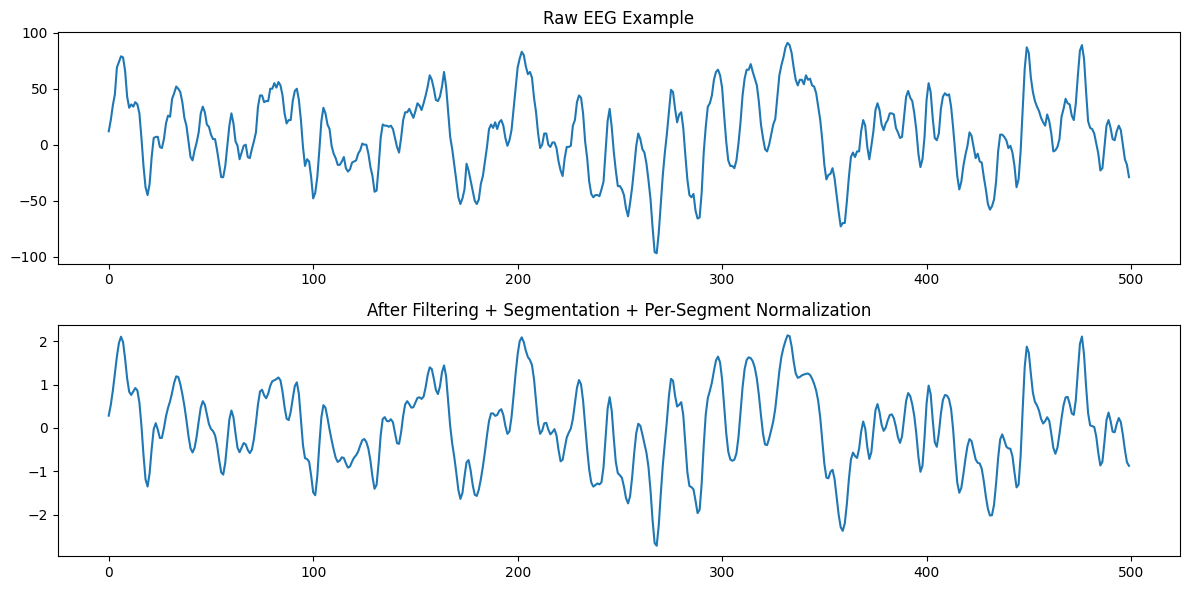

D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\O: Found 100 text files
D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\N: Found 100 text files
D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\F: Found 100 text files
D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures\S: Found 100 text files
Saved → X: (3500, 1024), y: (3500,)
Preprocessing complete!


In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch

# ----------------------------------------------------
#  Bandpass + Notch Filter
# ----------------------------------------------------
def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, data)
    
    # Notch filter at 50Hz to remove powerline noise
    f0 = 50.0
    Q = 30.0
    b_notch, a_notch = iirnotch(f0/(fs/2), Q)
    filtered = filtfilt(b_notch, a_notch, filtered)
    
    return filtered

# ----------------------------------------------------
#  Preprocessing with Overlapping Segments THEN Normalization
# ----------------------------------------------------
def preprocess_signal(signal, seg_len=1024, overlap=0.5, fs=173.61):

    # 1) Filtering
    filtered = bandpass_filter(signal, 0.5, 40, fs)

    # 2) Segmentation (NO normalization yet)
    step = int(seg_len * (1 - overlap))
    segments = []

    for start in range(0, len(filtered) - seg_len + 1, step):
        seg = filtered[start:start + seg_len]
        segments.append(seg)

    segments = np.array(segments)

    # 3) Z-score normalization **per segment**
    norm_segments = np.zeros_like(segments)
    for i in range(len(segments)):
        seg = segments[i]
        mean = np.mean(seg)
        std = np.std(seg) + 1e-8
        norm_segments[i] = (seg - mean) / std

    return norm_segments, filtered

# ----------------------------------------------------
#  Load & Preprocess Dataset
# ----------------------------------------------------
def load_and_preprocess_bonn(root_dir, save_dir, seg_len=1024, overlap=0.5, plot_example=True):

    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    all_segments, all_labels = [], []
    plotted = False

    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "*.txt"))

        print(f"{folder_path}: Found {len(files)} text files")

        class_segments = []
        for file in files:
            try:
                data = np.loadtxt(file)
                segments, filtered = preprocess_signal(data, seg_len=seg_len, overlap=overlap)

                # Plot once
                if plot_example and not plotted:
                    plt.figure(figsize=(12,6))
                    plt.subplot(2,1,1)
                    plt.plot(data[:500])
                    plt.title("Raw EEG Example")

                    plt.subplot(2,1,2)
                    plt.plot(segments[0][:500])
                    plt.title("After Filtering + Segmentation + Per-Segment Normalization")
                    plt.tight_layout()
                    plt.show()
                    plotted = True

                class_segments.append(segments)

            except Exception as e:
                print(f"Error in {file}: {e}")

        if not class_segments:
            continue

        class_segments = np.vstack(class_segments)
        labels = np.full(class_segments.shape[0], label)

        all_segments.append(class_segments)
        all_labels.append(labels)

    X = np.vstack(all_segments)
    y = np.concatenate(all_labels)

    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, "ALL_X.npy"), X)
    np.save(os.path.join(save_dir, "ALL_y.npy"), y)

    print(f"Saved → X: {X.shape}, y: {y.shape}")
    return X, y

# ----------------------------------------------------
#  Main
# ----------------------------------------------------
if __name__ == "__main__":
    root = r"D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures"
    save_dir = os.path.join(root, "preprocessed-overlap")

    X, y = load_and_preprocess_bonn(root, save_dir, seg_len=1024, overlap=0.5)
    print("Preprocessing complete!")


D:\FCIS Content\Fourth year\GP\GP-Epileptic-seizures\Z: Found 100 text files


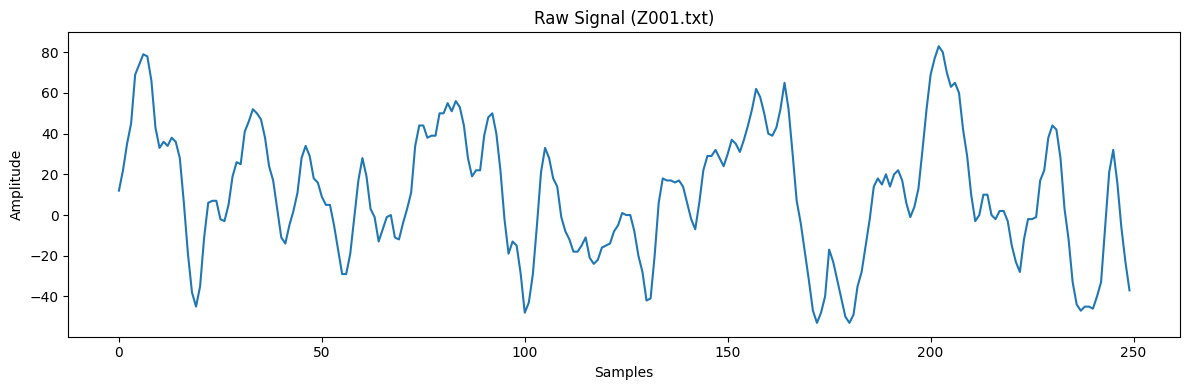

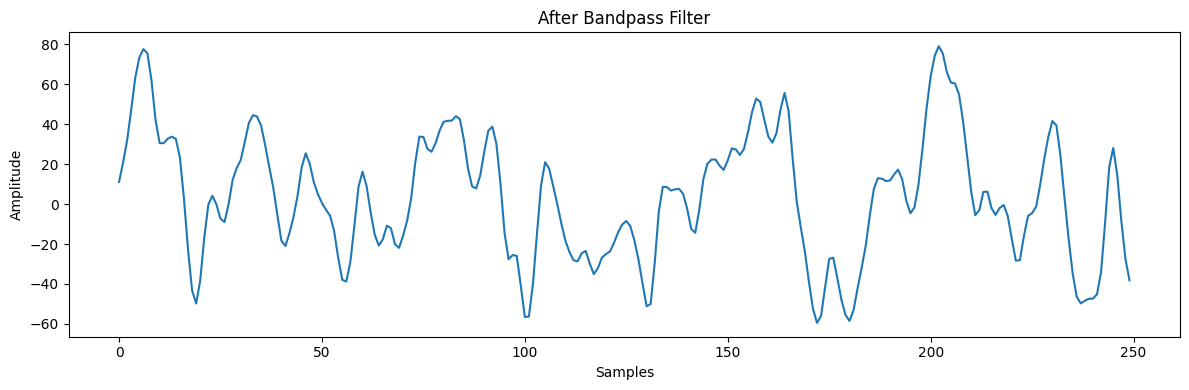

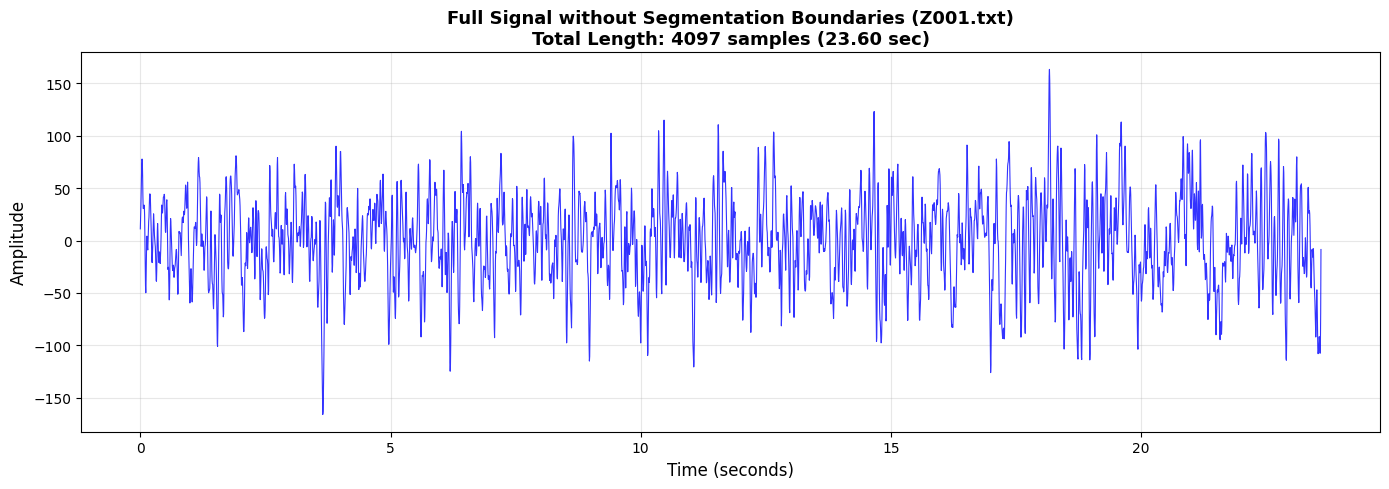

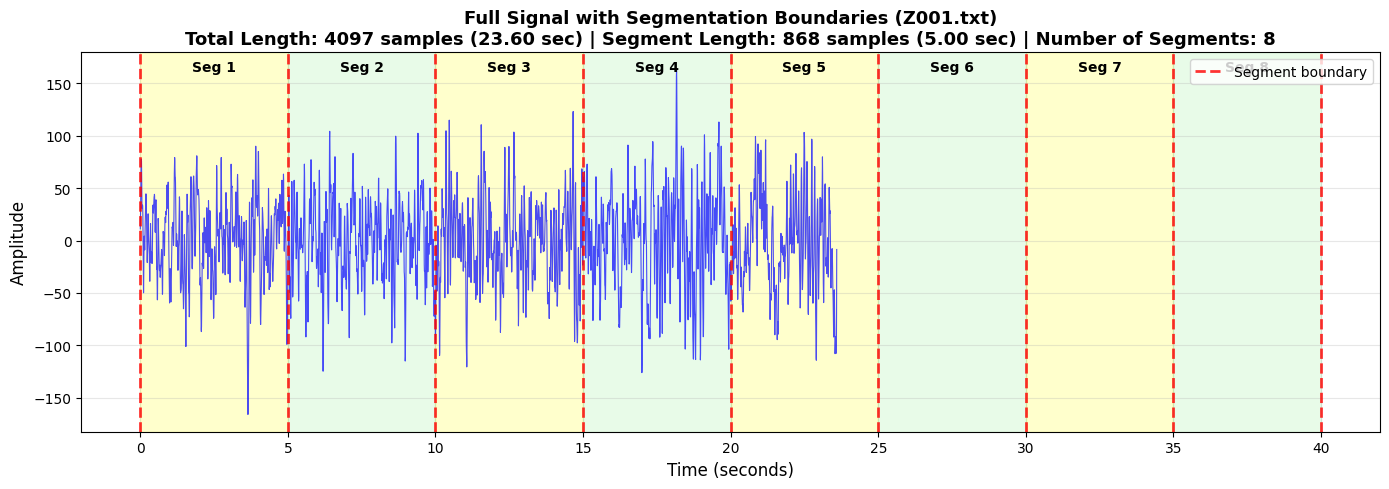

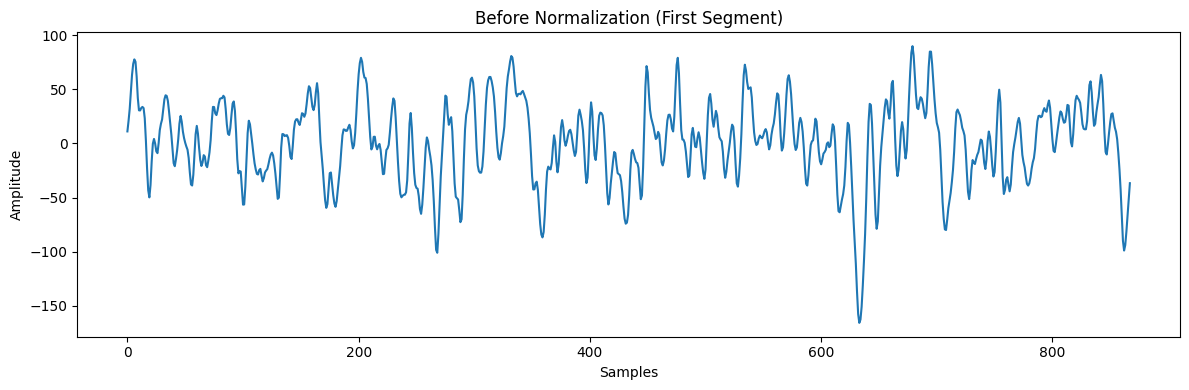

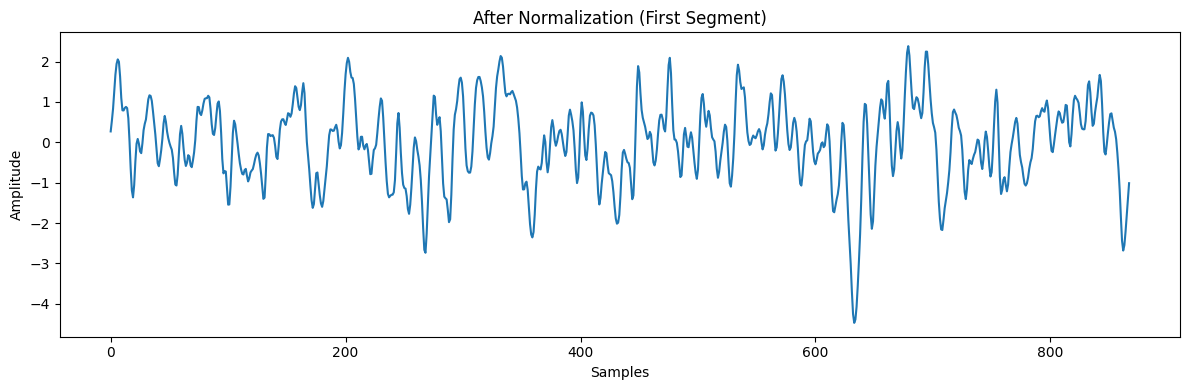

Saved NORMAL → (800, 868) to NPY & TXT
D:\FCIS Content\Fourth year\GP\GP-Epileptic-seizures\O: Found 100 text files
Saved NORMAL → (800, 868) to NPY & TXT
D:\FCIS Content\Fourth year\GP\GP-Epileptic-seizures\N: Found 100 text files
Saved INTERICTAL → (800, 868) to NPY & TXT
D:\FCIS Content\Fourth year\GP\GP-Epileptic-seizures\F: Found 100 text files
Saved INTERICTAL → (800, 868) to NPY & TXT
D:\FCIS Content\Fourth year\GP\GP-Epileptic-seizures\S: Found 100 text files
Saved ICTAL → (800, 868) to NPY & TXT
All data merged and saved → X: (4000, 868), y: (4000,), file_ids: (4000,)
Total unique files: 500
Preprocessing complete!


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import savemat

# Bandpass Filter

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Preprocessing Function

def preprocess_signal(signal, fs=173.61, segment_length=None):
    # Bandpass Filter
    filtered = bandpass_filter(signal, 0.5, 50, fs)

    # Segmentation WITH OVERLAP
    if segment_length is None:
        segment_length = int(5 * fs)  # 5-second segments = 868 samples
    
    step_size = int(segment_length * (1 - 0.5))  # 50% overlap = 434 samples
    
    segments = []
    for start in range(0, len(filtered) - segment_length + 1, step_size):
        end = start + segment_length
        segments.append(filtered[start:end])
    
    segments = np.array(segments)

    # Z-score normalization (per segment)
    normed_segments = np.zeros_like(segments)
    for i in range(segments.shape[0]):
        mean = segments[i].mean()
        std = segments[i].std()
        if std > 0:  # Avoid division by zero
            normed_segments[i] = (segments[i] - mean) / std
        else:
            normed_segments[i] = segments[i] - mean  # Just center if std=0

    return normed_segments, filtered, segments


def plot_segmentation_detailed(filtered, segments, fs=173.61, segment_length=None, filename=""):
   
    if segment_length is None:
        segment_length = int(5 * fs)
    
    num_segments = len(segments)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Plot the full filtered signal
    time = np.arange(len(filtered)) / fs
    ax.plot(time, filtered, 'b-', linewidth=0.8, alpha=0.7)
    
    # Add vertical lines to show segment boundaries
    for i in range(num_segments + 1):
        segment_time = i * segment_length / fs
        ax.axvline(x=segment_time, color='red', linestyle='--', 
                   linewidth=2, alpha=0.8, label='Segment boundary' if i == 0 else '')
    
    # Shade different segments with alternating colors
    for i in range(num_segments):
        start_time = i * segment_length / fs
        end_time = (i + 1) * segment_length / fs
        color = 'yellow' if i % 2 == 0 else 'lightgreen'
        ax.axvspan(start_time, end_time, alpha=0.2, color=color)
        # Add segment labels
        mid_time = (start_time + end_time) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.9, f'Seg {i+1}', 
                ha='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    
    title = f'Full Signal with Segmentation Boundaries'
    if filename:
        title += f' ({filename})'
    title += f'\nTotal Length: {len(filtered)} samples ({len(filtered)/fs:.2f} sec) | '
    title += f'Segment Length: {segment_length} samples ({segment_length/fs:.2f} sec) | '
    title += f'Number of Segments: {num_segments}'
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Load & Preprocess Dataset with File ID Tracking

def load_and_preprocess_bonn(root_dir, save_dir, plot_example=True):
    # Map folders to classes
    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    all_segments, all_labels, all_file_ids = [], [], []
    plotted = False
    global_file_id = 0  # Unique ID for each file

    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "**", "*.txt"), recursive=True)

        print(f"{folder_path}: Found {len(files)} text files")

        class_segments = []
        class_file_ids = []
        
        for i, file in enumerate(files):
            try:
                data = np.loadtxt(file)
                normed_segments, filtered, segments = preprocess_signal(data)

                # Plot one example
                if plot_example and not plotted:
                    # 1. Raw Signal
                    plt.figure(figsize=(12, 4))
                    plt.plot(data[:250])
                    plt.title(f"Raw Signal ({os.path.basename(file)})")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()

                    # 2. After Bandpass Filter (first 250 samples)
                    plt.figure(figsize=(12, 4))
                    plt.plot(filtered[:250])
                    plt.title("After Bandpass Filter")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()

                    # 3. Full Filtered Signal BEFORE Segmentation (NEW)
                    plt.figure(figsize=(14, 5))
                    time_full = np.arange(len(filtered)) / 173.61
                    plt.plot(time_full, filtered, 'b-', linewidth=0.8, alpha=0.8)
                    plt.xlabel('Time (seconds)', fontsize=12)
                    plt.ylabel('Amplitude', fontsize=12)
                    plt.title(f'Full Signal without Segmentation Boundaries ({os.path.basename(file)})\n' +
                             f'Total Length: {len(filtered)} samples ({len(filtered)/173.61:.2f} sec)',
                             fontsize=13, fontweight='bold')
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                    # 4. Detailed Segmentation Visualization AFTER Segmentation
                    plot_segmentation_detailed(filtered, segments, 
                                             fs=173.61, 
                                             segment_length=int(5*173.61),
                                             filename=os.path.basename(file))

                    plt.figure(figsize=(12, 4))
                    plt.plot(segments[0])
                    plt.title("Before Normalization (First Segment)")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    
                    # 5. After Normalization (First Segment)
                    plt.figure(figsize=(12, 4))
                    plt.plot(normed_segments[0])
                    plt.title("After Normalization (First Segment)")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    
                    plotted = True

                # ✅ KEY FIX: Assign same file_id to ALL segments from this file
                file_ids = np.full(len(normed_segments), global_file_id)
                
                class_segments.append(normed_segments)
                class_file_ids.append(file_ids)
                
                global_file_id += 1  # Increment for next file
                
            except Exception as e:
                print(f"Error reading {file}: {e}")

        if not class_segments:
            print(f"No valid data found for {folder}")
            continue

        class_segments = np.vstack(class_segments)
        class_file_ids = np.concatenate(class_file_ids)
        labels = np.full(len(class_segments), label)
        
        all_segments.append(class_segments)
        all_labels.append(labels)
        all_file_ids.append(class_file_ids)

        # --- Save per class ---
        os.makedirs(save_dir, exist_ok=True)

        np.save(os.path.join(save_dir, f"{label}_X.npy"), class_segments)
        np.save(os.path.join(save_dir, f"{label}_y.npy"), labels)
        np.save(os.path.join(save_dir, f"{label}_file_ids.npy"), class_file_ids)  # ✅ Save file IDs
        np.savetxt(os.path.join(save_dir, f"{label}_X.txt"), class_segments, fmt="%.6f")
        np.savetxt(os.path.join(save_dir, f"{label}_y.txt"), labels, fmt="%s")

        print(f"Saved {label} → {class_segments.shape} to NPY & TXT")

    # --- Merge all ---
    if not all_segments:
        raise RuntimeError("❌ No valid data loaded! Check folder paths or file format.")

    X = np.vstack(all_segments)
    y = np.concatenate(all_labels)
    file_ids = np.concatenate(all_file_ids)  # ✅ Merge file IDs

    np.save(os.path.join(save_dir, "ALL_X.npy"), X)
    np.save(os.path.join(save_dir, "ALL_y.npy"), y)
    np.save(os.path.join(save_dir, "ALL_file_ids.npy"), file_ids)  # ✅ Save file IDs
    np.savetxt(os.path.join(save_dir, "ALL_X.txt"), X, fmt="%.6f")
    np.savetxt(os.path.join(save_dir, "ALL_y.txt"), y, fmt="%s")

    print(f"All data merged and saved → X: {X.shape}, y: {y.shape}, file_ids: {file_ids.shape}")
    print(f"Total unique files: {len(np.unique(file_ids))}")

    return X, y, file_ids

# Main
if __name__ == "__main__":
    root = r"D:\FCIS Content\Fourth year\GP\GP-Epileptic-seizures"  # Path containing Z, O, N, F, S folders
    save_dir = os.path.join(root, "preprocessed_hakim")

    X, y, file_ids = load_and_preprocess_bonn(root, save_dir, plot_example=True)
    print("Preprocessing complete!")

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import savemat
# from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Bandpass Filter

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Preprocessing Function

def preprocess_signal(signal, fs=173.61, segment_length=None):
    # Bandpass Filter
    filtered = bandpass_filter(signal, 0.5, 50, fs)

    # Segmentation WITH OVERLAP
    if segment_length is None:
        segment_length = int(5 * fs)  # 5-second segments = 868 samples
    
    step_size = int(segment_length * (1 - 0.5))  # 50% overlap = 434 samples
    
    segments = []
    for start in range(0, len(filtered) - segment_length + 1, step_size):
        end = start + segment_length
        segments.append(filtered[start:end])
    
    segments = np.array(segments)

    # Z-score normalization (per segment)
    normed_segments = np.zeros_like(segments)
    for i in range(segments.shape[0]):
        mean = segments[i].mean()
        std = segments[i].std()
        if std > 0:  # Avoid division by zero
            normed_segments[i] = (segments[i] - mean) / std
        else:
            normed_segments[i] = segments[i] - mean  # Just center if std=0

    return normed_segments, filtered, segments


def plot_segmentation_detailed(filtered, segments, fs=173.61, segment_length=None, filename=""):
   
    if segment_length is None:
        segment_length = int(5 * fs)
    
    num_segments = len(segments)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Plot the full filtered signal
    time = np.arange(len(filtered)) / fs
    ax.plot(time, filtered, 'b-', linewidth=0.8, alpha=0.7)
    
    # Add vertical lines to show segment boundaries
    for i in range(num_segments + 1):
        segment_time = i * segment_length / fs
        ax.axvline(x=segment_time, color='red', linestyle='--', 
                   linewidth=2, alpha=0.8, label='Segment boundary' if i == 0 else '')
    
    # Shade different segments with alternating colors
    for i in range(num_segments):
        start_time = i * segment_length / fs
        end_time = (i + 1) * segment_length / fs
        color = 'yellow' if i % 2 == 0 else 'lightgreen'
        ax.axvspan(start_time, end_time, alpha=0.2, color=color)
        # Add segment labels
        mid_time = (start_time + end_time) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.9, f'Seg {i+1}', 
                ha='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    
    title = f'Full Signal with Segmentation Boundaries'
    if filename:
        title += f' ({filename})'
    title += f'\nTotal Length: {len(filtered)} samples ({len(filtered)/fs:.2f} sec) | '
    title += f'Segment Length: {segment_length} samples ({segment_length/fs:.2f} sec) | '
    title += f'Number of Segments: {num_segments}'
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Load & Preprocess Dataset with File ID Tracking
def load_raw_files(root_dir):
    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    raw_signals = []
    raw_labels = []
    file_paths = []

    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "**", "*.txt"), recursive=True)

        for f in files:
            try:
                sig = np.loadtxt(f)
                raw_signals.append(sig)
                raw_labels.append(label)
                file_paths.append(f)
            except:
                print("Error loading:", f)

    return np.array(raw_signals, dtype=object), np.array(raw_labels), file_paths


# ----------------------------------------------------------
#            APPLY YOUR PREPROCESSING ON K-FOLD
# ----------------------------------------------------------

def apply_kfold_preprocessing(root_dir, save_dir, n_folds=5):

    os.makedirs(save_dir, exist_ok=True)

    raw_signals, raw_labels, file_paths = load_raw_files(root_dir)

    label_map = {"NORMAL":0, "INTERICTAL":1, "ICTAL":2}
    y_raw = np.array([label_map[l] for l in raw_labels])

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(kf.split(raw_signals,y_raw)):

        print(f"\n========== Fold {fold+1}/{n_folds} ==========")

        X_train_list, y_train_list, fileid_train = [], [], []
        X_test_list,  y_test_list,  fileid_test  = [], [], []

        # ----------------------
        # TRAIN FILES
        # ----------------------
        for i in train_idx:
            raw = raw_signals[i]
            segs, _, _ = preprocess_signal(raw)    # ← USING YOUR FUNCTION

            X_train_list.append(segs)
            y_train_list.append(np.full(len(segs), y_raw[i]))
            fileid_train.append(np.full(len(segs), i))

        # ----------------------
        # TEST FILES
        # ----------------------
        for i in test_idx:
            raw = raw_signals[i]
            segs, _, _ = preprocess_signal(raw)    # ← USING YOUR FUNCTION

            X_test_list.append(segs)
            y_test_list.append(np.full(len(segs), y_raw[i]))
            fileid_test.append(np.full(len(segs), i))

        # Merge
        X_train = np.vstack(X_train_list)
        y_train = np.concatenate(y_train_list)
        fileid_train = np.concatenate(fileid_train)

        X_test = np.vstack(X_test_list)
        y_test = np.concatenate(y_test_list)
        fileid_test = np.concatenate(fileid_test)

        # Save each fold
        np.save(os.path.join(save_dir, f"fold_{fold}_X_train.npy"), X_train)
        np.save(os.path.join(save_dir, f"fold_{fold}_y_train.npy"), y_train)
        np.save(os.path.join(save_dir, f"fold_{fold}_fileids_train.npy"), fileid_train)

        np.save(os.path.join(save_dir, f"fold_{fold}_X_test.npy"), X_test)
        np.save(os.path.join(save_dir, f"fold_{fold}_y_test.npy"), y_test)
        np.save(os.path.join(save_dir, f"fold_{fold}_fileids_test.npy"), fileid_test)

        print("Train:", X_train.shape, "Test:", X_test.shape)

    print("\nAll folds saved successfully!")




# Main
if __name__ == "__main__":
    root = r"D:/FCIS Content/Fourth year/GP/GP-Epileptic-seizures"
    save = os.path.join(root, "Preprocessing_Updated_Kfold")

    apply_kfold_preprocessing(root, save, n_folds=5)


========== Fold 1/5 ==========
Train: (3200, 868) Test: (800, 868)

========== Fold 2/5 ==========
Train: (3200, 868) Test: (800, 868)

========== Fold 3/5 ==========
Train: (3200, 868) Test: (800, 868)

========== Fold 4/5 ==========
Train: (3200, 868) Test: (800, 868)

========== Fold 5/5 ==========
Train: (3200, 868) Test: (800, 868)

All folds saved successfully!
